In [2]:
import pandas as pd
from sklearn import preprocessing
from sklearn.preprocessing import MultiLabelBinarizer
from datetime import datetime
from pandas.api.types import is_numeric_dtype
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
np.random.seed(29)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import StackingClassifier
from matplotlib import pyplot
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import warnings
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings('ignore')
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.naive_bayes import GaussianNB

In [3]:
# importuje przygotowane ramki

y_train = pd.read_csv('y_train.csv')
y_test = pd.read_csv('y_test.csv')
X_train = pd.read_csv('X_train.csv', low_memory=False)
X_test = pd.read_csv('X_test.csv', low_memory=False)

y_train = y_train['Credit_Score']
y_test = y_test['Credit_Score']
X_train.drop(columns=['Unnamed: 0'], inplace=True)
X_test.drop(columns=['Unnamed: 0'], inplace=True)

In [4]:
# sprawdzam feature importance

xgb_model = xgb.XGBClassifier(random_state=1)
feature_names = X_train.columns.values
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [5]:
# usuwam najmniej ważne kolumny

importances = xgb_model.feature_importances_

indices = np.argsort(importances)

feature_names = X_train.columns.values

suma = 0

for i in indices:
    print(f"{feature_names[i]}: {importances[i]}")
    suma += importances[i]
    print("sum:", suma)
    if suma < 0.1:
        X_train.drop(columns=[feature_names[i]], inplace=True)
        X_test.drop(columns=[feature_names[i]], inplace=True)


Occupation________: 0.002846386982128024
sum: 0.002846386982128024
Payment_of_Min_Amount_NM: 0.0037567124236375093
sum: 0.0066030994057655334
Credit_Utilization_Ratio: 0.003925201948732138
sum: 0.010528301354497671
Not Specified: 0.004470033571124077
sum: 0.014998334925621748
Monthly_Balance: 0.004575368482619524
sum: 0.019573703408241272
payment_value: 0.004613145720213652
sum: 0.024186849128454924
Amount_invested_monthly: 0.004755117930471897
sum: 0.02894196705892682
Occupation_Teacher: 0.004889668896794319
sum: 0.03383163595572114
Occupation_Scientist: 0.005083649419248104
sum: 0.038915285374969244
Occupation_Media_Manager: 0.005095916800200939
sum: 0.04401120217517018
Student Loan: 0.005138459615409374
sum: 0.04914966179057956
Occupation_Doctor: 0.005213799886405468
sum: 0.054363461676985025
Occupation_Accountant: 0.005353242624551058
sum: 0.05971670430153608
Occupation_Engineer: 0.005396323278546333
sum: 0.06511302758008242
Credit_History_Age: 0.005498805083334446
sum: 0.070611832

In [6]:
# usuwam kolumny nieproporcjonalnie ważne

X_train.drop(columns=['Credit_Mix_Good', 'Credit_Mix_Standard'], inplace=True)
X_test.drop(columns=['Credit_Mix_Good', 'Credit_Mix_Standard'], inplace=True)

In [7]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49000 entries, 0 to 48999
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Annual_Income              49000 non-null  float64
 1   Num_Bank_Accounts          49000 non-null  float64
 2   Num_Credit_Card            49000 non-null  float64
 3   Interest_Rate              49000 non-null  float64
 4   Delay_from_due_date        49000 non-null  float64
 5   Num_of_Delayed_Payment     49000 non-null  float64
 6   Changed_Credit_Limit       49000 non-null  float64
 7   Num_Credit_Inquiries       49000 non-null  float64
 8   Outstanding_Debt           49000 non-null  float64
 9   Total_EMI_per_month        49000 non-null  float64
 10  spent                      49000 non-null  int64  
 11  Credit-Builder Loan        49000 non-null  int64  
 12  Debt Consolidation Loan    49000 non-null  int64  
 13  Mortgage Loan              49000 non-null  int

In [8]:
# wcześniejsza ewaluacja skuteczności modeli wskazała na hierarchie: xgb > cart > aboost > bayes
# cart wcześniej zoptymalizowany

In [14]:
# definiuje siatki do przeszukania
param_grid_xgb = {'learning_rate': [0.01, 0.1, 0.5],
                  'max_depth': [3, 5, 7],
                  'n_estimators': [50, 200, 400],
                 'subsample': [0.6, 0.8, 1.0],
                 'colsample_bytree': [0.6, 0.8, 1.0]}

param_grid_aboost = {'learning_rate': [0.01, 0.1, 0.5],
                     'n_estimators': [50, 100, 200]}

param_grid_bayes = {'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]}

xgb = XGBClassifier()
aboost = AdaBoostClassifier()
bayes = GaussianNB()

grid_search_xgb = GridSearchCV(xgb, param_grid_xgb, cv=5, scoring='accuracy', verbose = 2)
grid_search_aboost = GridSearchCV(aboost, param_grid_aboost, cv=5, scoring='accuracy', verbose = 2)
grid_search_bayes = GridSearchCV(bayes, param_grid_bayes, cv=5, scoring='accuracy', verbose = 3)

In [31]:
# wykonuje grid search

In [17]:
grid_search_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.6; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.6; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.6; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.6; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.6; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.6s
[CV] END colsamp

[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=1.0; total time=   4.3s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=1.0; total time=   4.3s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=1.0; total time=   4.4s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=1.0; total time=   4.2s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=5, n_estimators=400, subsample=0.6; total time=  10.3s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=5, n_estimators=400, subsample=0.6; total time=   9.5s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=5, n_estimators=400, subsample=0.6; total time=   9.8s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=5, n_estimators=400, subsample=0.6; total time=   9.4s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=5, n_estima

[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, n_estimators=200, subsamp

[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=5, n_estimators=400, subsample=0.6; total time=   9.1s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=5, n_estimators=400, subsample=0.8; total time=   8.7s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=5, n_estimators=400, subsample=0.8; total time=   9.1s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=5, n_estimators=400, subsample=0.8; total time=   9.3s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=5, n_estimators=400, subsample=0.8; total time=   8.8s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=5, n_estimators=400, subsample=0.8; total time=   9.2s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=5, n_estimators=400, subsample=1.0; total time=   8.0s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=5, n_estimators=400, subsample=1.0; total time=   8.2s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=5, n_estimators=400,

[CV] END colsample_bytree=0.6, learning_rate=0.5, max_depth=3, n_estimators=200, subsample=0.6; total time=   2.9s
[CV] END colsample_bytree=0.6, learning_rate=0.5, max_depth=3, n_estimators=200, subsample=0.6; total time=   3.1s
[CV] END colsample_bytree=0.6, learning_rate=0.5, max_depth=3, n_estimators=200, subsample=0.6; total time=   3.0s
[CV] END colsample_bytree=0.6, learning_rate=0.5, max_depth=3, n_estimators=200, subsample=0.6; total time=   2.9s
[CV] END colsample_bytree=0.6, learning_rate=0.5, max_depth=3, n_estimators=200, subsample=0.8; total time=   2.9s
[CV] END colsample_bytree=0.6, learning_rate=0.5, max_depth=3, n_estimators=200, subsample=0.8; total time=   2.9s
[CV] END colsample_bytree=0.6, learning_rate=0.5, max_depth=3, n_estimators=200, subsample=0.8; total time=   3.0s
[CV] END colsample_bytree=0.6, learning_rate=0.5, max_depth=3, n_estimators=200, subsample=0.8; total time=   3.0s
[CV] END colsample_bytree=0.6, learning_rate=0.5, max_depth=3, n_estimators=200,

[CV] END colsample_bytree=0.6, learning_rate=0.5, max_depth=5, n_estimators=400, subsample=1.0; total time=   8.0s
[CV] END colsample_bytree=0.6, learning_rate=0.5, max_depth=5, n_estimators=400, subsample=1.0; total time=   8.0s
[CV] END colsample_bytree=0.6, learning_rate=0.5, max_depth=7, n_estimators=50, subsample=0.6; total time=   1.7s
[CV] END colsample_bytree=0.6, learning_rate=0.5, max_depth=7, n_estimators=50, subsample=0.6; total time=   1.6s
[CV] END colsample_bytree=0.6, learning_rate=0.5, max_depth=7, n_estimators=50, subsample=0.6; total time=   1.5s
[CV] END colsample_bytree=0.6, learning_rate=0.5, max_depth=7, n_estimators=50, subsample=0.6; total time=   1.5s
[CV] END colsample_bytree=0.6, learning_rate=0.5, max_depth=7, n_estimators=50, subsample=0.6; total time=   1.5s
[CV] END colsample_bytree=0.6, learning_rate=0.5, max_depth=7, n_estimators=50, subsample=0.8; total time=   1.5s
[CV] END colsample_bytree=0.6, learning_rate=0.5, max_depth=7, n_estimators=50, subsam

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0; total time=   2.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0; total time=   2.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0; total time=   2.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0; total time=   2.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0; total time=   2.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=400, subsample=0.6; total time=   6.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=400, subsample=0.6; total time=   6.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=400, subsample=0.6; total time=   6.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estima

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=50, subsample=0.8; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=50, subsample=0.8; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=50, subsample=0.8; total time=   1.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=50, subsample=0.8; total time=   1.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=50, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=50, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=50, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=50, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=50,

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=400, subsample=0.6; total time=   6.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=400, subsample=0.6; total time=   6.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=400, subsample=0.8; total time=   6.4s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=400, subsample=0.8; total time=   6.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=400, subsample=0.8; total time=   6.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=400, subsample=0.8; total time=   6.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=400, subsample=0.8; total time=   6.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=400, subsample=1.0; total time=   5.6s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=400,

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=0.6; total time=   6.4s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=0.6; total time=   6.9s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=0.6; total time=   6.4s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=0.6; total time=   7.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=0.6; total time=   6.5s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=0.8; total time=   6.6s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=0.8; total time=   6.7s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=0.8; total time=   6.4s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=200,

[CV] END colsample_bytree=0.8, learning_rate=0.5, max_depth=3, n_estimators=400, subsample=1.0; total time=   5.4s
[CV] END colsample_bytree=0.8, learning_rate=0.5, max_depth=3, n_estimators=400, subsample=1.0; total time=   5.2s
[CV] END colsample_bytree=0.8, learning_rate=0.5, max_depth=3, n_estimators=400, subsample=1.0; total time=   5.4s
[CV] END colsample_bytree=0.8, learning_rate=0.5, max_depth=5, n_estimators=50, subsample=0.6; total time=   1.3s
[CV] END colsample_bytree=0.8, learning_rate=0.5, max_depth=5, n_estimators=50, subsample=0.6; total time=   1.3s
[CV] END colsample_bytree=0.8, learning_rate=0.5, max_depth=5, n_estimators=50, subsample=0.6; total time=   1.1s
[CV] END colsample_bytree=0.8, learning_rate=0.5, max_depth=5, n_estimators=50, subsample=0.6; total time=   1.1s
[CV] END colsample_bytree=0.8, learning_rate=0.5, max_depth=5, n_estimators=50, subsample=0.6; total time=   1.1s
[CV] END colsample_bytree=0.8, learning_rate=0.5, max_depth=5, n_estimators=50, subsa

[CV] END colsample_bytree=0.8, learning_rate=0.5, max_depth=7, n_estimators=200, subsample=0.8; total time=   6.6s
[CV] END colsample_bytree=0.8, learning_rate=0.5, max_depth=7, n_estimators=200, subsample=1.0; total time=   6.2s
[CV] END colsample_bytree=0.8, learning_rate=0.5, max_depth=7, n_estimators=200, subsample=1.0; total time=   6.0s
[CV] END colsample_bytree=0.8, learning_rate=0.5, max_depth=7, n_estimators=200, subsample=1.0; total time=   6.3s
[CV] END colsample_bytree=0.8, learning_rate=0.5, max_depth=7, n_estimators=200, subsample=1.0; total time=   6.0s
[CV] END colsample_bytree=0.8, learning_rate=0.5, max_depth=7, n_estimators=200, subsample=1.0; total time=   6.0s
[CV] END colsample_bytree=0.8, learning_rate=0.5, max_depth=7, n_estimators=400, subsample=0.6; total time=  13.5s
[CV] END colsample_bytree=0.8, learning_rate=0.5, max_depth=7, n_estimators=400, subsample=0.6; total time=  13.8s
[CV] END colsample_bytree=0.8, learning_rate=0.5, max_depth=7, n_estimators=400,

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=50, subsample=0.8; total time=   1.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=50, subsample=0.8; total time=   1.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=50, subsample=0.8; total time=   1.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=50, subsample=0.8; total time=   1.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=50, subsample=0.8; total time=   1.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=50, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=50, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=50, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=50,

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=400, subsample=0.6; total time=  14.7s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=400, subsample=0.6; total time=  14.6s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=400, subsample=0.6; total time=  14.5s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=400, subsample=0.6; total time=  14.5s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=400, subsample=0.8; total time=  14.7s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=400, subsample=0.8; total time=  14.5s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=400, subsample=0.8; total time=  14.5s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=400, subsample=0.8; total time=  14.6s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estima

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.6; total time=   5.2s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.6; total time=   4.8s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.6; total time=   4.8s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.6; total time=   5.2s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.6; total time=   4.9s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.8; total time=   4.8s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=200, s

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=400, subsample=1.0; total time=  13.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=400, subsample=1.0; total time=  12.6s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=400, subsample=1.0; total time=  13.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=400, subsample=1.0; total time=  12.9s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=400, subsample=1.0; total time=  12.9s
[CV] END colsample_bytree=1.0, learning_rate=0.5, max_depth=3, n_estimators=50, subsample=0.6; total time=   0.8s
[CV] END colsample_bytree=1.0, learning_rate=0.5, max_depth=3, n_estimators=50, subsample=0.6; total time=   0.8s
[CV] END colsample_bytree=1.0, learning_rate=0.5, max_depth=3, n_estimators=50, subsample=0.6; total time=   0.7s
[CV] END colsample_bytree=1.0, learning_rate=0.5, max_depth=3, n_estimators=50, sub

[CV] END colsample_bytree=1.0, learning_rate=0.5, max_depth=5, n_estimators=200, subsample=0.8; total time=   4.7s
[CV] END colsample_bytree=1.0, learning_rate=0.5, max_depth=5, n_estimators=200, subsample=0.8; total time=   4.8s
[CV] END colsample_bytree=1.0, learning_rate=0.5, max_depth=5, n_estimators=200, subsample=0.8; total time=   5.2s
[CV] END colsample_bytree=1.0, learning_rate=0.5, max_depth=5, n_estimators=200, subsample=1.0; total time=   4.3s
[CV] END colsample_bytree=1.0, learning_rate=0.5, max_depth=5, n_estimators=200, subsample=1.0; total time=   4.3s
[CV] END colsample_bytree=1.0, learning_rate=0.5, max_depth=5, n_estimators=200, subsample=1.0; total time=   4.5s
[CV] END colsample_bytree=1.0, learning_rate=0.5, max_depth=5, n_estimators=200, subsample=1.0; total time=   4.4s
[CV] END colsample_bytree=1.0, learning_rate=0.5, max_depth=5, n_estimators=200, subsample=1.0; total time=   4.3s
[CV] END colsample_bytree=1.0, learning_rate=0.5, max_depth=5, n_estimators=400,

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                   

In [16]:
grid_search_aboost.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END ................learning_rate=0.01, n_estimators=50; total time=   1.7s
[CV] END ................learning_rate=0.01, n_estimators=50; total time=   1.8s
[CV] END ................learning_rate=0.01, n_estimators=50; total time=   1.7s
[CV] END ................learning_rate=0.01, n_estimators=50; total time=   1.7s
[CV] END ................learning_rate=0.01, n_estimators=50; total time=   1.7s
[CV] END ...............learning_rate=0.01, n_estimators=100; total time=   3.5s
[CV] END ...............learning_rate=0.01, n_estimators=100; total time=   3.5s
[CV] END ...............learning_rate=0.01, n_estimators=100; total time=   3.6s
[CV] END ...............learning_rate=0.01, n_estimators=100; total time=   3.5s
[CV] END ...............learning_rate=0.01, n_estimators=100; total time=   3.5s
[CV] END ...............learning_rate=0.01, n_estimators=200; total time=   7.2s
[CV] END ...............learning_rate=0.01, n_est

GridSearchCV(cv=5, estimator=AdaBoostClassifier(),
             param_grid={'learning_rate': [0.01, 0.1, 0.5],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy', verbose=2)

In [15]:
grid_search_bayes.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END ...............var_smoothing=1e-09;, score=0.585 total time=   0.0s
[CV 2/5] END ...............var_smoothing=1e-09;, score=0.581 total time=   0.0s
[CV 3/5] END ...............var_smoothing=1e-09;, score=0.586 total time=   0.0s
[CV 4/5] END ...............var_smoothing=1e-09;, score=0.588 total time=   0.0s
[CV 5/5] END ...............var_smoothing=1e-09;, score=0.588 total time=   0.0s
[CV 1/5] END ...............var_smoothing=1e-08;, score=0.585 total time=   0.0s
[CV 2/5] END ...............var_smoothing=1e-08;, score=0.581 total time=   0.0s
[CV 3/5] END ...............var_smoothing=1e-08;, score=0.586 total time=   0.0s
[CV 4/5] END ...............var_smoothing=1e-08;, score=0.588 total time=   0.0s
[CV 5/5] END ...............var_smoothing=1e-08;, score=0.588 total time=   0.0s
[CV 1/5] END ...............var_smoothing=1e-07;, score=0.585 total time=   0.0s
[CV 2/5] END ...............var_smoothing=1e-07;,

GridSearchCV(cv=5, estimator=GaussianNB(),
             param_grid={'var_smoothing': [1e-09, 1e-08, 1e-07, 1e-06, 1e-05]},
             scoring='accuracy', verbose=3)

In [18]:
print("XGB:")
print("Best hyperparameters:", grid_search_xgb.best_params_)
print("Best accuracy score:", grid_search_xgb.best_score_)

print("ABOOST:")
print("Best hyperparameters:", grid_search_aboost.best_params_)
print("Best accuracy score:", grid_search_aboost.best_score_)

print("BAYES:")
print("Best hyperparameters:", grid_search_bayes.best_params_)
print("Best accuracy score:", grid_search_bayes.best_score_)

XGB:
Best hyperparameters: {'colsample_bytree': 0.6, 'learning_rate': 0.5, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1.0}
Best accuracy score: 0.7711632653061226
ABOOST:
Best hyperparameters: {'learning_rate': 0.5, 'n_estimators': 200}
Best accuracy score: 0.6544489795918368
BAYES:
Best hyperparameters: {'var_smoothing': 1e-05}
Best accuracy score: 0.5860816326530612


In [20]:
xgb_estim = grid_search_xgb.best_estimator_
y_pred_xgb = xgb_estim.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))

Accuracy: 0.7768


In [21]:
aboost_estim = grid_search_aboost.best_estimator_
y_pred_aboost = aboost_estim.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred_aboost))

Accuracy: 0.6502


In [22]:
bayes_estim = grid_search_bayes.best_estimator_
y_pred_bayes = bayes_estim.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred_bayes))

Accuracy: 0.5808666666666666


In [24]:
# Przedstawienie najlepszego osiągniętego votingu

xgb_best = XGBClassifier(colsample_bytree= 0.6, 
                         learning_rate= 0.5, 
                         max_depth= 7, 
                         n_estimators= 200, 
                         subsample= 1.0)

aboost_best = AdaBoostClassifier(learning_rate = 0.5,
                                n_estimators = 200)

breaker = DecisionTreeClassifier(random_state = 1,
                                criterion='entropy',
                                max_depth=6,
                                min_samples_leaf=2,
                                min_samples_split=2)

estimators = [('xgb', xgb_best), ('aboost', aboost_best), ('breaker', breaker)]

In [25]:
hard_vote = VotingClassifier(estimators=estimators, voting='hard')
hard_vote.fit(X_train, y_train)
y_pred = hard_vote.predict(X_test)
print('hard_vote acc', accuracy_score(y_test, y_pred))

hard_vote acc 0.7241


In [8]:
# najlepszy zawodnik
level0 = list()
level0.append(('xgb1', XGBClassifier(max_depth=7, n_estimators=500)))
level0.append(('xgb2', XGBClassifier()))
level0.append(('cart', DecisionTreeClassifier(random_state=1,
                                              criterion='entropy',
                                              max_depth=6,
                                              min_samples_leaf=2,
                                              min_samples_split=2)))
level0.append(('cart2', DecisionTreeClassifier(random_state=1,
                                              criterion='gini',
                                              max_depth=6,
                                              min_samples_leaf=2,
                                              min_samples_split=2)))
level0.append(('bayes', GaussianNB(var_smoothing=1e-3)))
level0.append(('knn', KNeighborsClassifier(algorithm='brute', metric='manhattan', n_jobs=-1)))
level1 = XGBClassifier(max_depth=6, n_estimators=100)
model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.7913666666666667


In [11]:
pred_prob = model.predict_proba(X_test)

In [14]:
print('accuracy:', accuracy_score(y_test, y_pred))
print(' precision:', precision_score(y_test, y_pred, average='macro'))
print(' recall:', recall_score(y_test, y_pred, average='macro'))
print(' f1:', f1_score(y_test, y_pred, average='macro'))
print(' roc_auc:', roc_auc_score(y_test, pred_prob, multi_class='ovo'))

accuracy: 0.7913666666666667
 precision: 0.7767312142329419
 recall: 0.7924243344857977
 f1: 0.7833843320595998
 roc_auc: 0.9179301733666887


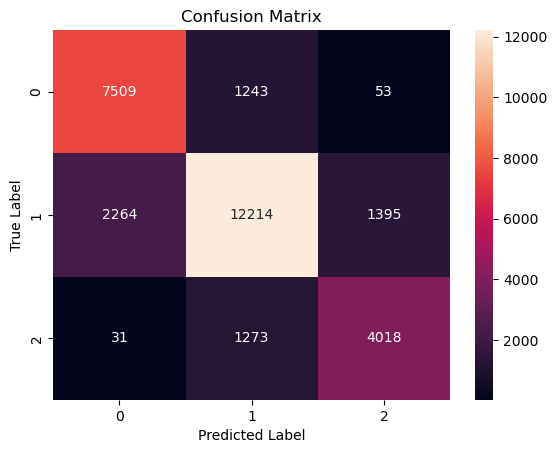

In [16]:
conf_matrix = confusion_matrix(y_test, y_pred)

sns.heatmap(conf_matrix, annot=True, fmt="d")

# set plot labels
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# show plot
plt.show()